To understand the nature of data, its a standard approach to calculate feature importance using one of the ensemble methods like XG Boosting Classifier. In the below experiment we will calculate the important features among given 2000 features of colon tumor dataset.

In [2]:
from xgboost import XGBClassifier
from matplotlib import pyplot
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
df = pd.read_csv(
    filepath_or_buffer='/home/kushwanth/Downloads/ColonTumor/colonTumor.data',
    header=None,
    sep=',')

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Above code loads the colon tumor dataset into df variable. As 0 to 1999 values are dimensions/features and 2000th value is label we have taken the features. Standardize features by removing the mean and scaling to unit variance
Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the data set. Mean and standard deviation are then stored to be used on later data using the transform method.

In [5]:
# split data into X and y
X = df.ix[:,0:1999].values
X_std = StandardScaler().fit_transform(X)

In [6]:
y_labs = df.ix[:,2000].values
y=np.zeros(62,dtype=np.int)
i=0
for value in df.ix[:,2000].values:
    if value=='positive':
        y[i]=int(1)
    else: y[i]=int(0)
    i=i+1
model1 = XGBClassifier()
model1.fit(X_std, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

Above code learns XG boosting classifier. The main advantage is feature importance in calculated as inbuilt feature.
Below plot shows the feature importance of each variable. From the plot we can take the threshold for minimum featue importance threshold can be between 0.02 to 0.03. Later in our heuristic experiment we will see that this is a valid tradeoff.

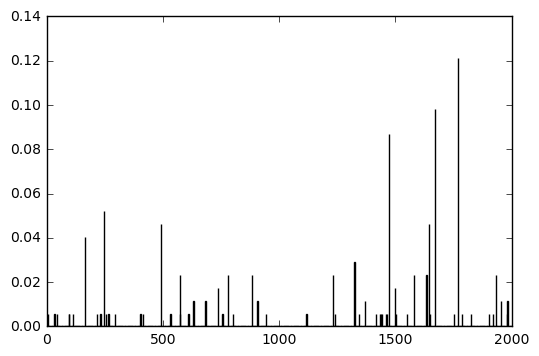

In [7]:
pyplot.bar(range(len(model1.feature_importances_)), model1.feature_importances_)
pyplot.show()

Now we are going to perform a heuristic experiment to check if the inference about the feature importance is valid or not. The problem statement is : what are the number of features required to ensure the 99% of original nature of data is captured. To do this we will take an arthematic progression of feature importance scores.

In [10]:
#range of 30 feature importance values
thres_range=np.arange(0.001,0.031,0.001)
print(thres_range)

[ 0.001  0.002  0.003  0.004  0.005  0.006  0.007  0.008  0.009  0.01
  0.011  0.012  0.013  0.014  0.015  0.016  0.017  0.018  0.019  0.02
  0.021  0.022  0.023  0.024  0.025  0.026  0.027  0.028  0.029  0.03 ]


In below code counts calculates the number of features that are above the given threshold. sums calculates the overall feature importance score for given threshold. The code is self explinatory

In [12]:
counts=[]
sums=[]
for thresh in thres_range:
    cur_count=0
    cur_sum=0
    for i in model1.feature_importances_:
        if i>=thresh:
            cur_sum+=i
            cur_count+=1
    counts.append(cur_count)
    sums.append(cur_sum)

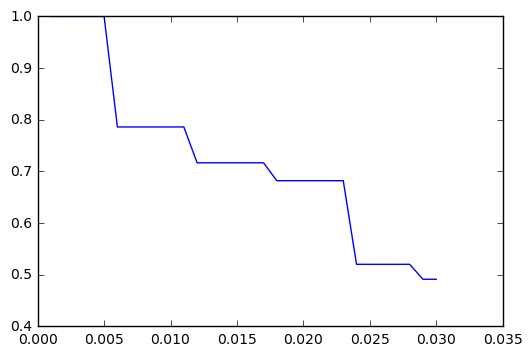

In [14]:
sums=np.array(sums)
pyplot.plot(thres_range, sums)
pyplot.show()

In [22]:
print(sums[3]) #0.03
print(sums[4]) #0.04
print(sums[5]) #0.05

0.999999977648
0.999999977648
0.786127150059


We can see from above graph at a threshold around 0.04, we can get 99% coverage of nature of data.
Below graph we will plot counts per threshold heuristic. From the below graph we can see that approx 60 features are more than enough to capture the  99% nature of data.

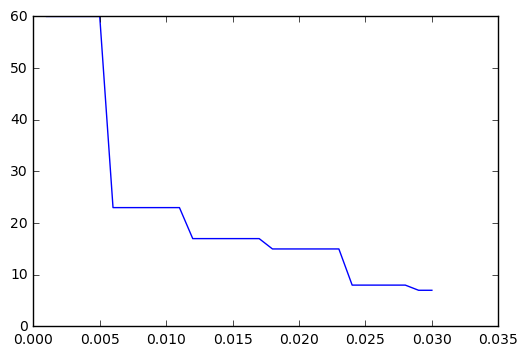

In [13]:
counts=np.array(counts)
pyplot.plot(thres_range, counts)
pyplot.show()

In [21]:
print(counts[3]) #0.03
print(counts[4]) #0.04
print(counts[5]) #0.05

60
60
23


From the experiments we can see that threshold can be fixed to 0.04 with number of features to 60.We will select the 60 features with highest values of feature importance and apply the classifiers like SVM,Random Forest.

Dimensionality reduction experiments :
Before going to classification we will test Dimensionality reduction using PCA. One intutive assumption is after the dimensionality reduction 99 or 98 percent of variability must be preserved in 60 or less features.

In [26]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
tot = sum(eig_vals)

#var_exp is similar to softmax or normalization as probability.
var_exp = [(i / tot) for i in eig_vals]
thres_range=np.arange(0.001,0.031,0.001)
print(thres_range)

[ 0.001  0.002  0.003  0.004  0.005  0.006  0.007  0.008  0.009  0.01
  0.011  0.012  0.013  0.014  0.015  0.016  0.017  0.018  0.019  0.02
  0.021  0.022  0.023  0.024  0.025  0.026  0.027  0.028  0.029  0.03 ]


In [31]:
print(sum(var_exp))  # summed up to one

(1+0j)


In [28]:
counts=[]
sums=[]
for thresh in thres_range:
    cur_count=0
    cur_sum=0
    for i in var_exp:
        if i>=thresh:
            cur_sum+=i
            cur_count+=1
    counts.append(cur_count)
    sums.append(cur_sum)

/usr/local/lib/python3.4/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


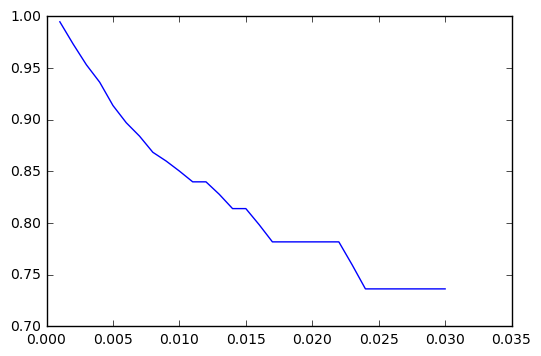

In [29]:
sums=np.array(sums)
pyplot.plot(thres_range, sums)
pyplot.show()

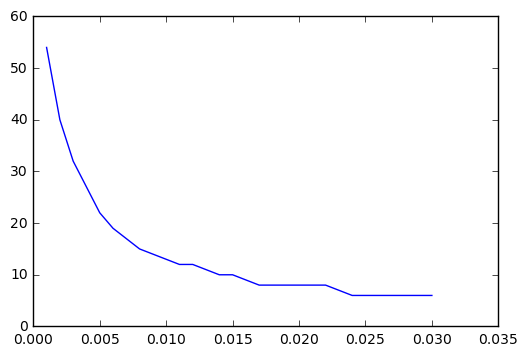

In [30]:
counts=np.array(counts)
pyplot.plot(thres_range, counts)
pyplot.show()

From above experiments we can see that 54 eigen valaue/vector pairs are enough to preserve 99% 
variability of the data. 

Also lets visualize the data using t-SNE so that we see the effectiveness of this manifold based method.
t-SNE was not able to capture the representation.

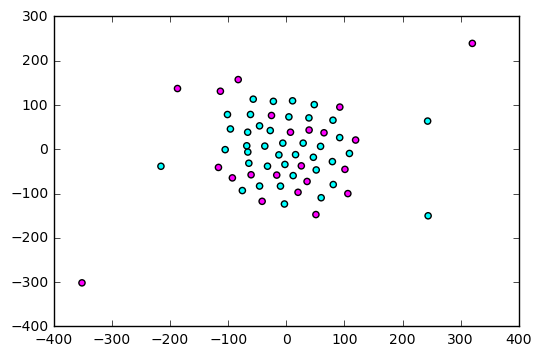

In [35]:
from sklearn.manifold import TSNE
import pylab
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
new_data=model.fit_transform(X_std)
pyplot.scatter(new_data[:,0], new_data[:,1],c=y,cmap=pylab.cm.cool)
pyplot.show()